In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

import time

In [53]:
train_df = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/test.csv")

# Data analysis

In [54]:
test_df.head().style.background_gradient(cmap='cividis')

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,nan,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,nan,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,nan,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,nan,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,nan,0,0,0,0,Prague_1_2024-03-20


In [55]:
train_df.head().style.background_gradient(cmap='cividis')

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.000000,nan,0,0,0,0,0,0,0,0.000000,0,0.000000,0.000000,1722.000000,32575.000000,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.000000,nan,0,0,0,0,0,0,0,0.000000,0,0.000000,0.000000,1688.000000,32507.000000,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.000000,nan,0,0,0,0,0,0,0,0.000000,0,0.000000,0.000000,1696.000000,32552.000000,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.000000,nan,0,0,0,0,0,0,0,0.000000,0,0.800000,0.000000,1681.000000,32423.000000,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.000000,nan,0,0,0,0,0,0,0,0.000000,0,0.500000,0.000000,1704.000000,32410.000000,Prague_1_2020-12-09


In [56]:
print('Train: ',min(train_df.date),max(train_df.date))
print('Test: ',min(test_df.date),max(test_df.date))

Train:  2020-12-05 2024-03-15
Test:  2024-03-16 2024-05-15


In [57]:
row_counts_df = train_df.groupby(['warehouse']).size().reset_index(name='row_count')
dates_df = train_df.groupby(['warehouse'])['date'].agg(['min', 'max']).reset_index()
dates_df.columns = ['warehouse', 'start_date', 'end_date']
train_summary = pd.merge(row_counts_df, dates_df, on=['warehouse'])
train_summary

,warehouse,row_count,start_date,end_date
0,Brno_1,1193,2020-12-05,2024-03-15
1,Budapest_1,1154,2020-12-05,2024-03-14
2,Frankfurt_1,629,2022-02-18,2024-03-15
3,Munich_1,785,2021-07-21,2024-03-15
4,Prague_1,1193,2020-12-05,2024-03-15
5,Prague_2,1193,2020-12-05,2024-03-15
6,Prague_3,1193,2020-12-05,2024-03-15


In [58]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [59]:
summary(train_df).style.background_gradient(cmap='cividis')

data shape: (7340, 18)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
warehouse,object,0,0.000000,7,nan,nan,Prague_1,Prague_1,Prague_1
date,object,0,0.000000,1193,nan,nan,2020-12-05,2020-12-06,2020-12-07
orders,float64,0,0.000000,4426,790.000000,18139.000000,6895.000000,6584.000000,7030.000000
holiday_name,object,7122,97.029973,24,nan,nan,nan,nan,nan
holiday,int64,0,0.000000,2,0.000000,1.000000,0,0,0
shutdown,int64,0,0.000000,2,0.000000,1.000000,0,0,0
mini_shutdown,int64,0,0.000000,2,0.000000,1.000000,0,0,0
shops_closed,int64,0,0.000000,2,0.000000,1.000000,0,0,0
winter_school_holidays,int64,0,0.000000,2,0.000000,1.000000,0,0,0
school_holidays,int64,0,0.000000,2,0.000000,1.000000,0,0,0


In [60]:
duplicates = train_df.duplicated()
num_duplicates = duplicates.sum()

print(f'The number of duplicates: {num_duplicates}')

The number of duplicates: 0


In [61]:
unique_warehouse = train_df['warehouse'].unique()
print(unique_warehouse)

['Prague_1' 'Brno_1' 'Prague_2' 'Prague_3' 'Munich_1' 'Frankfurt_1'
 'Budapest_1']


In [62]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [63]:
start_date = train_df['date'].min()
end_date = train_df['date'].max()
all_dates = pd.date_range(start=start_date, end=end_date)

for warehouse in unique_warehouse:
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    warehouse_dates = warehouse_data['date'].unique()
    missing_dates = all_dates[~all_dates.isin(warehouse_dates)]
   
    print(f"Missed dates for the warehouse {warehouse}:")
    print(missing_dates)
    print("\n")

Missed dates for the warehouse Prague_1:
DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)


Missed dates for the warehouse Brno_1:
DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)


Missed dates for the warehouse Prague_2:
DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)


Missed dates for the warehouse Prague_3:
DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)


Missed dates for the warehouse Munich_1:
DatetimeIndex(['2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14',
               ...
               '2024-01-07', '2024-01-14', '2024-01-21', '2024-01-28',
               '2024-02-04', '2024-02-11', '2024-02-18', '2024-02-25',
               

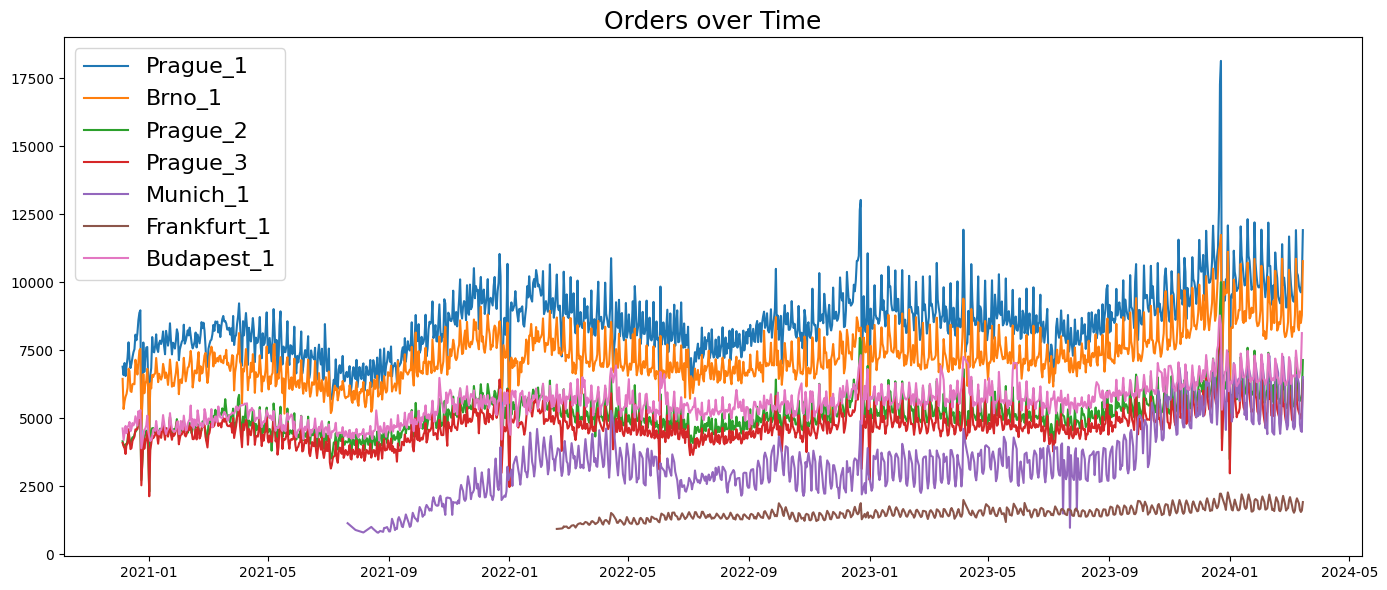

In [64]:
plt.figure(figsize=(14, 6))
for i, warehouse in enumerate(unique_warehouse):
    df_warehouse = train_df[train_df['warehouse'] == warehouse]
    sns.lineplot(x='date', y='orders', data=df_warehouse, label=warehouse)


plt.title('Orders over Time', fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=16) 
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [65]:
from datetime import datetime
date_start = datetime(2024, 3, 16)
date_end = datetime(2024, 5, 15)
delta = date_end - date_start

print(f"Number of days between {date_start.date()} and {date_end.date()}: {delta.days} days")

Number of days between 2024-03-16 and 2024-05-15: 60 days


# The moving average method

I chose the moving average and seasonal decomposition methods over the ARIMA model because they operate faster compared to SARIMA, which also considers seasonal components but would require substantial time to handle. Additionally, my methods are more robust against data outliers. They smooth the time series and extract overall trends and seasonal fluctuations, ignoring or reducing the impact of random outliers.
These methods offer simplicity, efficiency, and speed in handling time series data. And they are straightforward to implement.

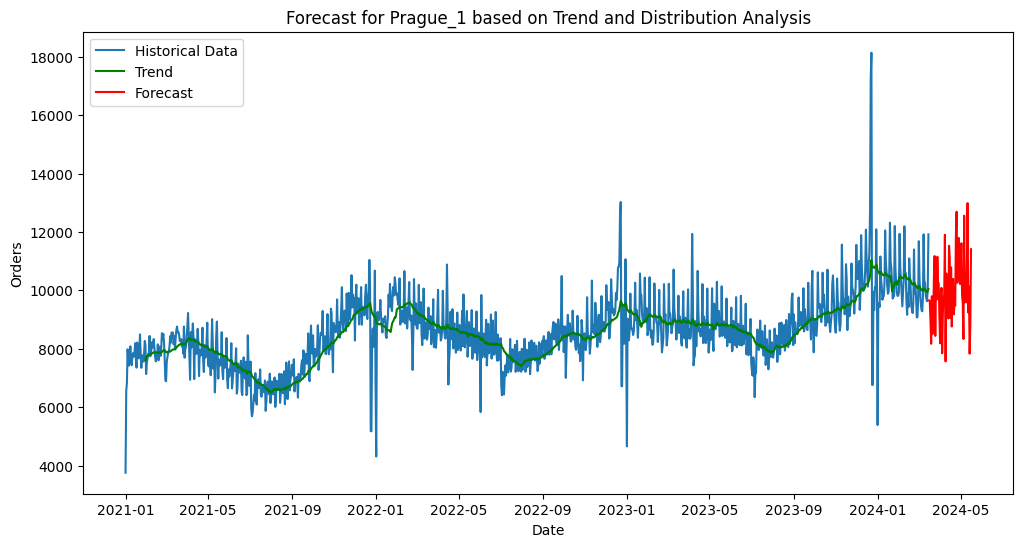

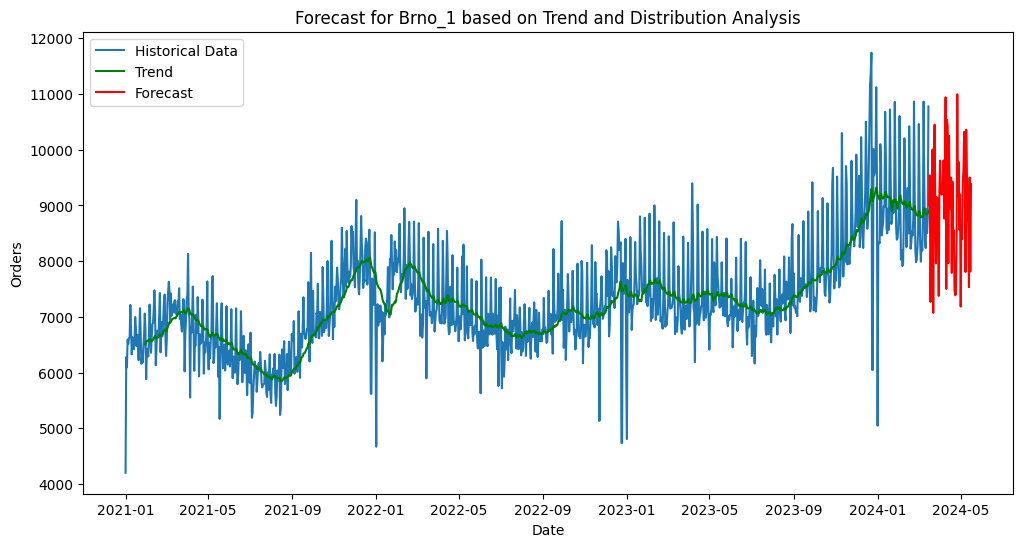

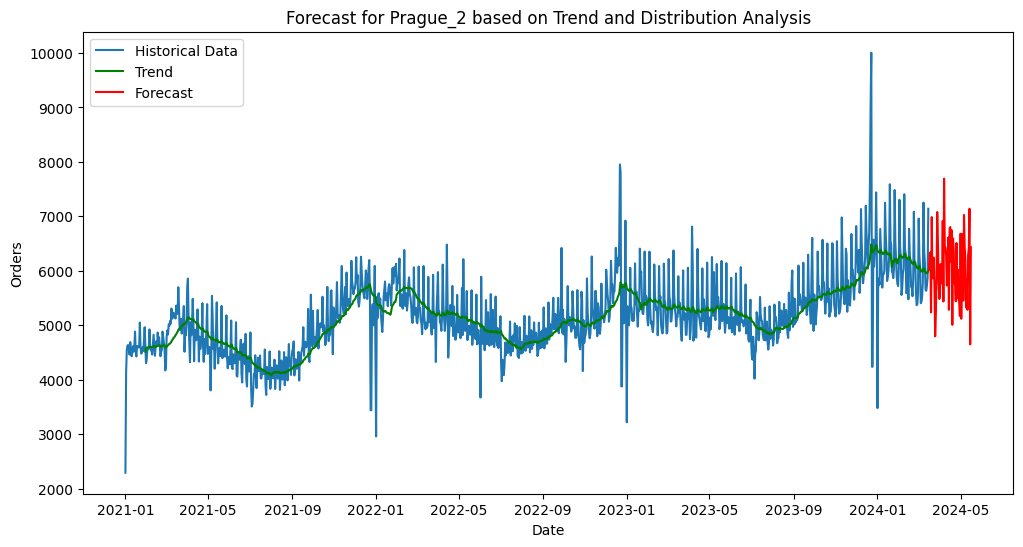

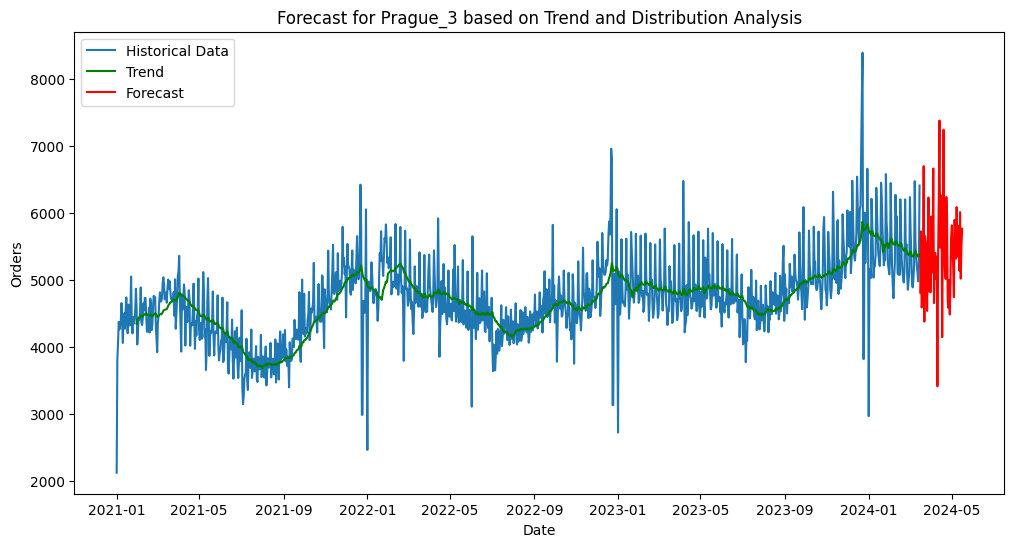

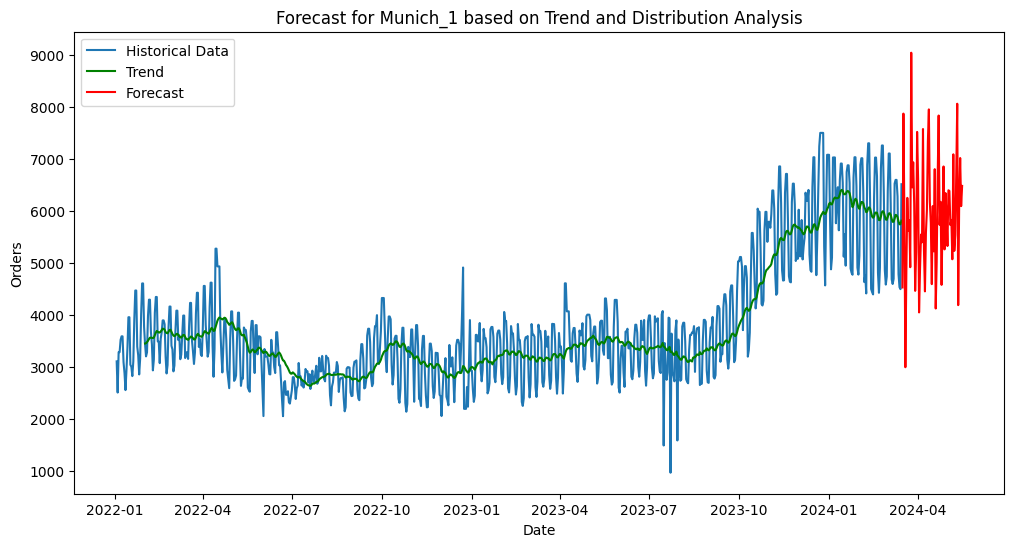

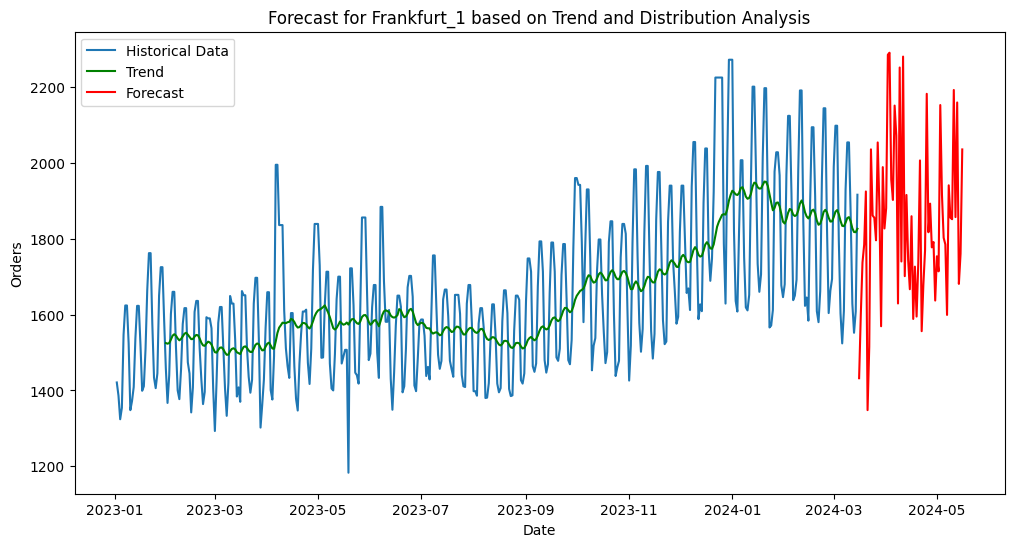

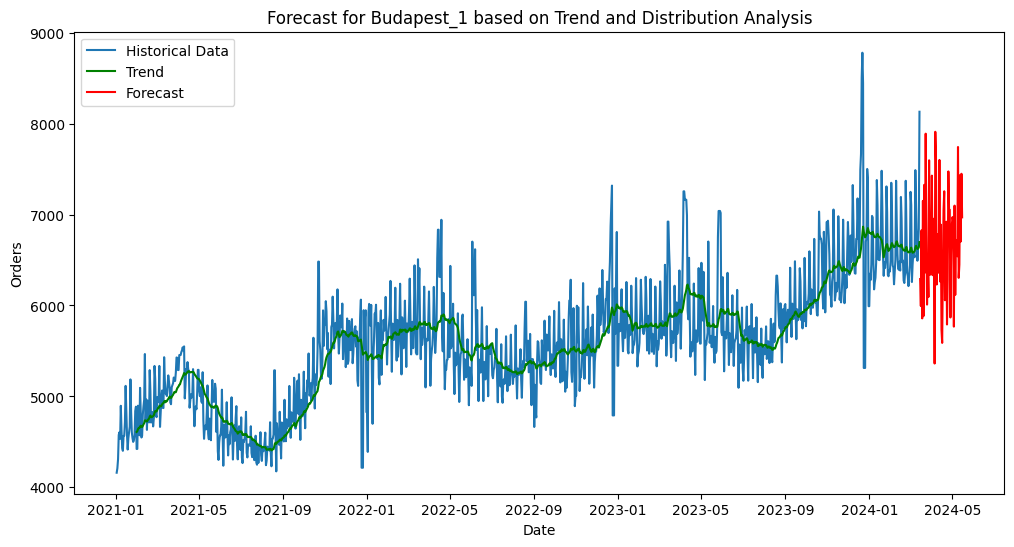

In [66]:
# A function for highlighting a trend using the moving average method
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Function for highlighting the seasonal component
def seasonal_decompose(data, period):
    seasonal = data.groupby(data.index.dayofyear).transform(lambda x: x - x.mean())
    return seasonal

def forecast(data, trend, seasonal, steps=62):
    forecast_values = trend[-1] + np.random.normal(0, np.std(data), steps)
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='D')[1:]
    return pd.DataFrame({'forecast': forecast_values}, index=forecast_index)

def prepare_warehouse_data(train_df, warehouse_name, exclude_years=[]):
    warehouse_data = train_df[train_df['warehouse'] == warehouse_name]
    
    for year in exclude_years:
        warehouse_data = warehouse_data[warehouse_data['date'].dt.year != year]
    
    warehouse_data.reset_index(drop=True, inplace=True)
    warehouse_data.set_index('date', inplace=True)
    warehouse_data = warehouse_data.asfreq('D')
    warehouse_data.fillna(method='ffill', inplace=True)
    
    return warehouse_data

warehouse_data = {}
warehouses = ['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1', 'Frankfurt_1', 'Budapest_1']

exclude_years = {
     'Prague_1': [2020],
     'Brno_1': [2020],
     'Prague_2': [2020],
     'Prague_3': [2020],
     'Munich_1': [2021],
     'Frankfurt_1': [2022],
     'Budapest_1': [2020]
}

for warehouse_name in warehouses:
    warehouse_data[warehouse_name] = prepare_warehouse_data(train_df, warehouse_name, exclude_years.get(warehouse_name, []))
    trend = moving_average(warehouse_data[warehouse_name]['orders'], window_size=30)
    seasonal = seasonal_decompose(warehouse_data[warehouse_name]['orders'], period=365)
    forecast_results = forecast(warehouse_data[warehouse_name]['orders'], trend, seasonal, steps=62)

    plt.figure(figsize=(12, 6))
    plt.plot(warehouse_data[warehouse_name]['orders'], label='Historical Data')
    plt.plot(trend, label='Trend', color='green')
    plt.plot(forecast_results.index, forecast_results['forecast'], label='Forecast', color='red')
    plt.title(f'Forecast for {warehouse_name} based on Trend and Distribution Analysis')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

# Three Sigma Rule

It is evident that there are outliers in January of each year, and judging by the dates, they precisely coincide with the missing dates that were filled. To detect and correct outliers in the time series data, I will use the Three Sigma Rule. This method is based on the standard deviation of the data. Outliers are identified as values lying outside the interval

<div style="text-align: center; font-size: 20px;">[μ - 3σ, μ + 3σ], </div>
    



where μ is the mean and σ is the standard deviation. Of course, I will adjust the values according to these outliers.

Outliers detected by Median Rule for Prague_1: [   0  184  357  358  365  720  721  730  825 1043 1064 1071 1078 1084
 1085 1086 1093 1095 1106 1113 1120 1127 1134 1155 1162 1169]
Outliers detected by Three Sigma Rule for Prague_1: [   0  183  184  185  191  204  218  232  357  358  365  517  730 1085
 1086 1095]


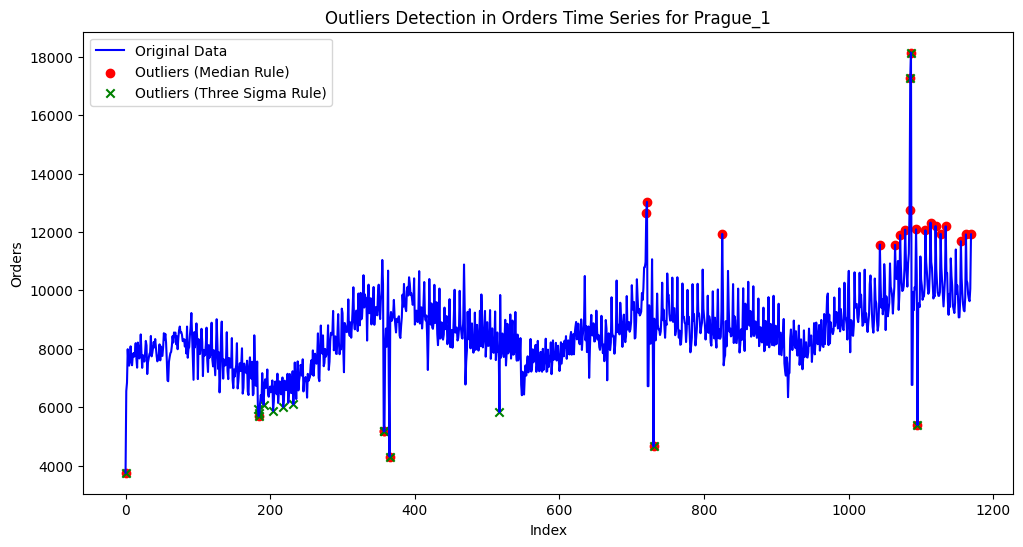

Outliers detected by Median Rule for Brno_1: [   0  365  722  723  730 1030 1043 1049 1057 1064 1071 1078 1079 1082
 1083 1084 1085 1086 1089 1091 1092 1093 1094 1095 1099 1100 1106 1107
 1113 1120 1121 1127 1134 1141 1148 1155 1162 1169]
Outliers detected by Three Sigma Rule for Brno_1: [   0  137  184  185  225  365  690  722  723  730 1084 1085 1086 1095]


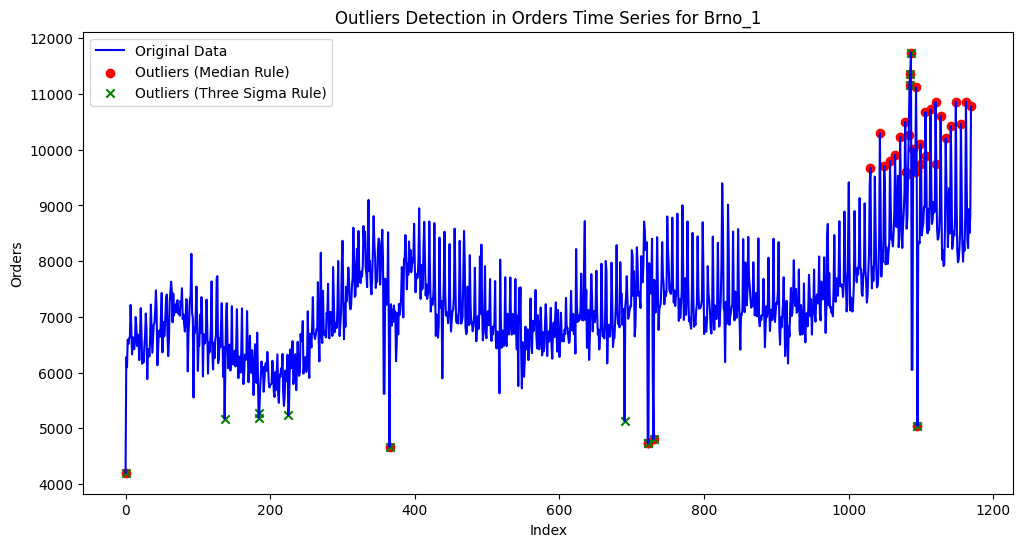

Outliers detected by Median Rule for Prague_2: [   0  184  357  358  365  720  721  728  730  825 1043 1064 1071 1078
 1084 1085 1086 1093 1095 1106 1113 1120 1127 1134 1148 1155 1162 1169]
Outliers detected by Three Sigma Rule for Prague_2: [   0  184  185  205  357  358  365  517  720  730 1085 1086 1095]


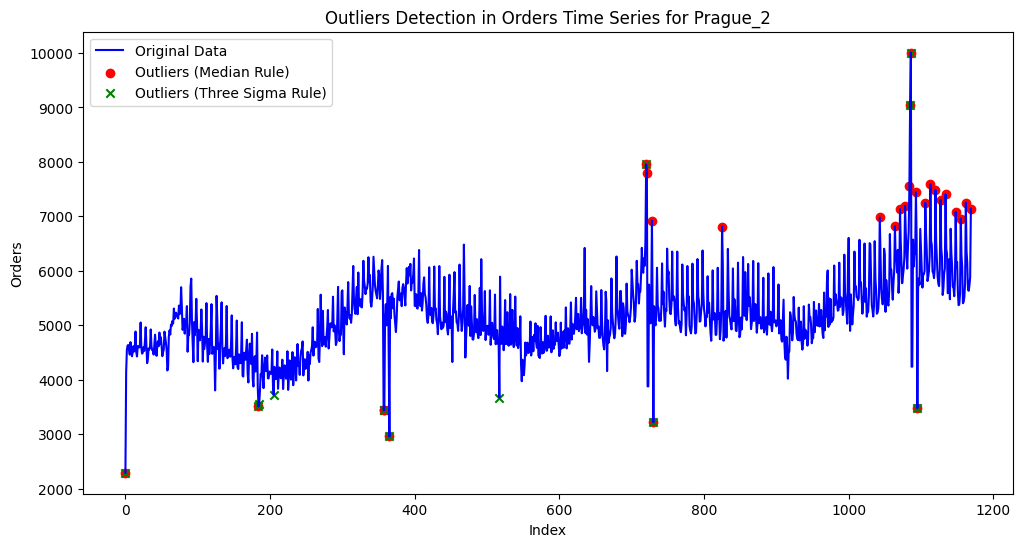

Outliers detected by Median Rule for Prague_3: [   0  184  185  355  357  358  365  517  720  721  722  723  730  825
 1043 1071 1078 1079 1083 1084 1085 1086 1093 1095 1099 1106 1113 1114
 1120 1127 1134 1141 1148 1155 1162 1169]
Outliers detected by Three Sigma Rule for Prague_3: [   0  183  184  185  191  205  218  232  251  357  358  365  517  722
  723  730 1085 1086 1095]


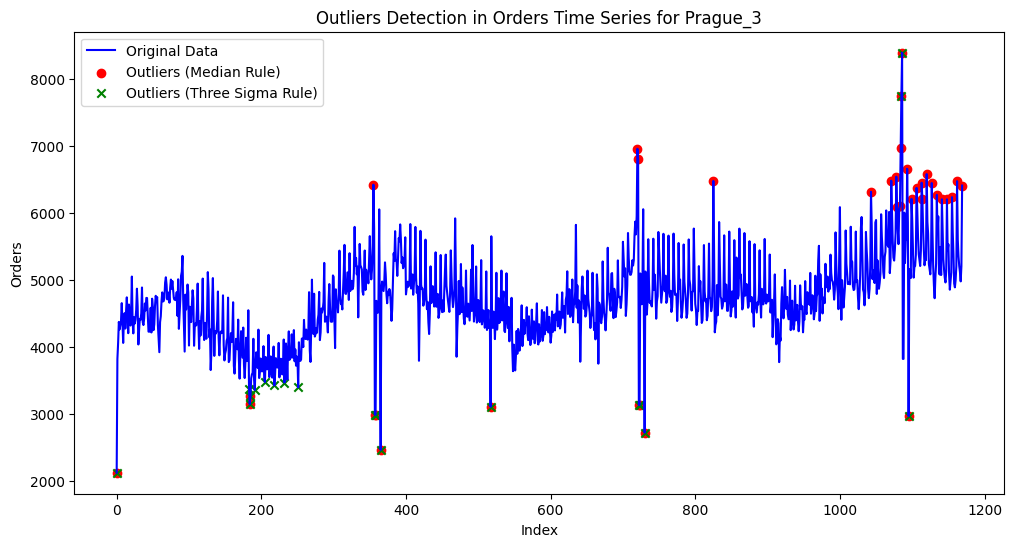

Outliers detected by Median Rule for Munich_1: [677 678 684 685 712 713 718 719 720 721 722 726 727 728 732 733 734 740
 741 746 747 748 753 754 755 760 761 762 767 768 769 775 776 777 781 782
 783 789 790 796 797]
Outliers detected by Three Sigma Rule for Munich_1: [566]


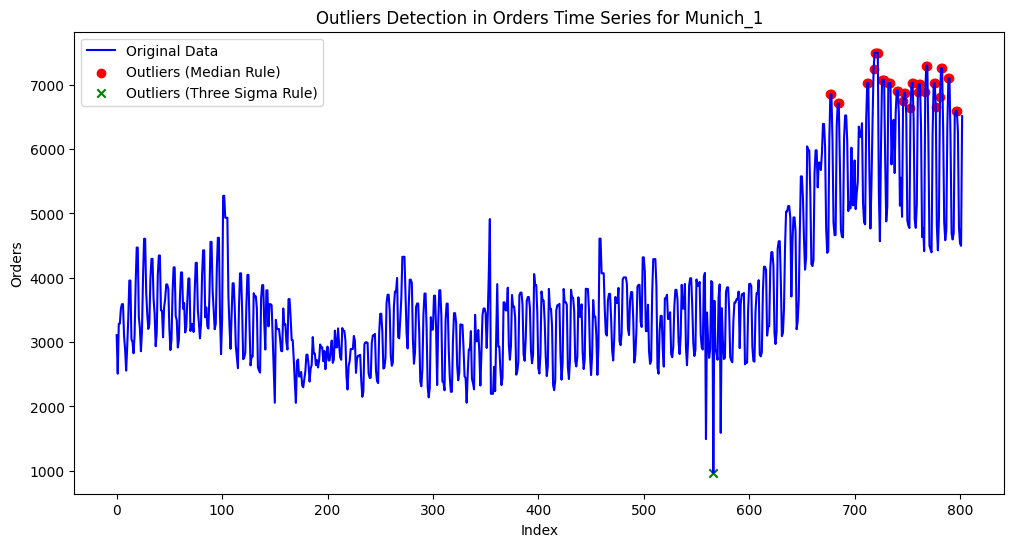

Outliers detected by Median Rule for Frankfurt_1: [354 355 356 357 358 362 363 364]
Outliers detected by Three Sigma Rule for Frankfurt_1: [137]


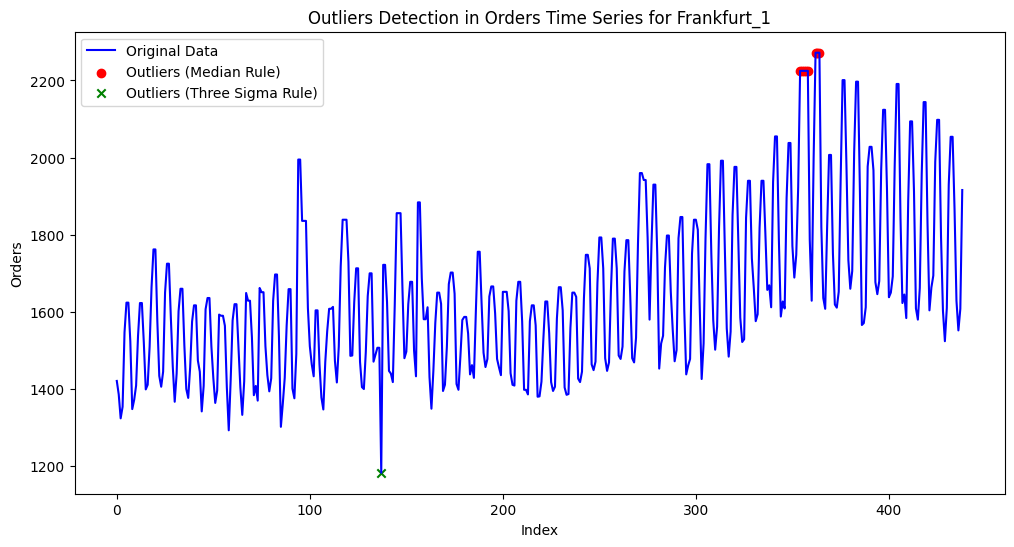

Outliers detected by Median Rule for Budapest_1: [1081 1082 1083 1084 1085 1091 1092 1112 1161 1167]
Outliers detected by Three Sigma Rule for Budapest_1: [   0  232 1083 1084 1085]


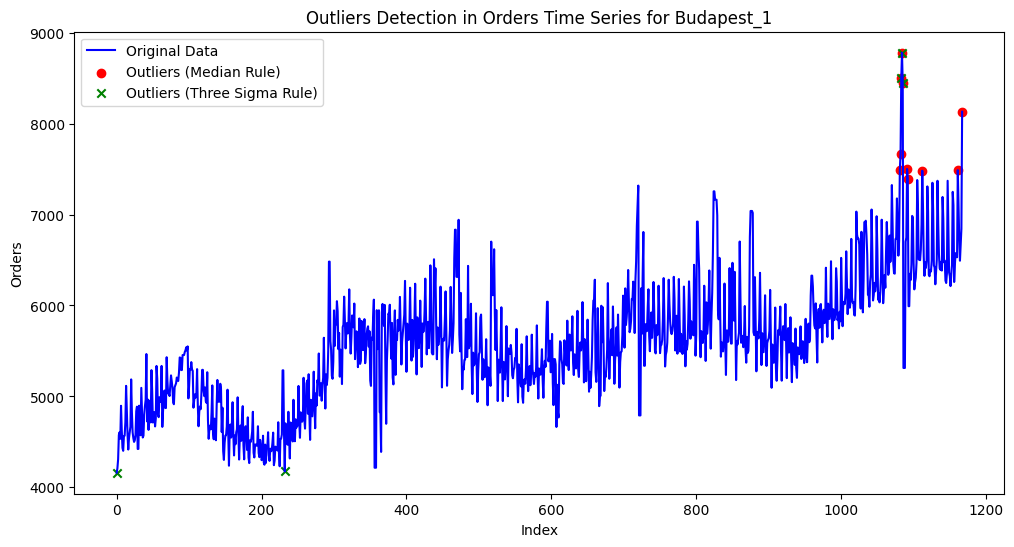

In [67]:
# Function for detecting outliers according to the median rule
def detect_outliers_median_rule(data, k=0.9):
    q1 = np.percentile(data, 17)
    q3 = np.percentile(data, 83)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

# Function for detecting outliers according to the three sigma rule
def detect_outliers_three_sigma(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    lower_bound = mean - 2 * std_dev
    upper_bound = mean + 4 * std_dev
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

for warehouse_name, data in warehouse_data.items():
    warehouse_data[warehouse_name] = data['orders'].to_frame()

for warehouse_name, data in warehouse_data.items():
    orders = data['orders'].values

    outliers_median = detect_outliers_median_rule(orders)
    print(f"Outliers detected by Median Rule for {warehouse_name}: {np.where(outliers_median)[0]}")

    outliers_three_sigma = detect_outliers_three_sigma(orders)
    print(f"Outliers detected by Three Sigma Rule for {warehouse_name}: {np.where(outliers_three_sigma)[0]}")

    cleaned_data_median_rule = orders[~outliers_median]
    cleaned_data_three_sigma = orders[~outliers_three_sigma]

    plt.figure(figsize=(12, 6))
    plt.plot(orders, label='Original Data', color='blue')
    plt.scatter(np.where(outliers_median)[0], orders[outliers_median], color='red', marker='o', label='Outliers (Median Rule)')
    plt.scatter(np.where(outliers_three_sigma)[0], orders[outliers_three_sigma], color='green', marker='x', label='Outliers (Three Sigma Rule)')
    plt.title(f'Outliers Detection in Orders Time Series for {warehouse_name}')
    plt.xlabel('Index')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

# Forecasting

Outliers detected by Median Rule for Prague_1: [   0  184  357  358  365  720  721  730  825 1043 1064 1071 1078 1084
 1085 1086 1093 1095 1106 1113 1120 1127 1134 1155 1162 1169]
Outliers detected by Three Sigma Rule for Prague_1: [   0  183  184  185  191  204  218  232  357  358  365  517  730 1085
 1086 1095]


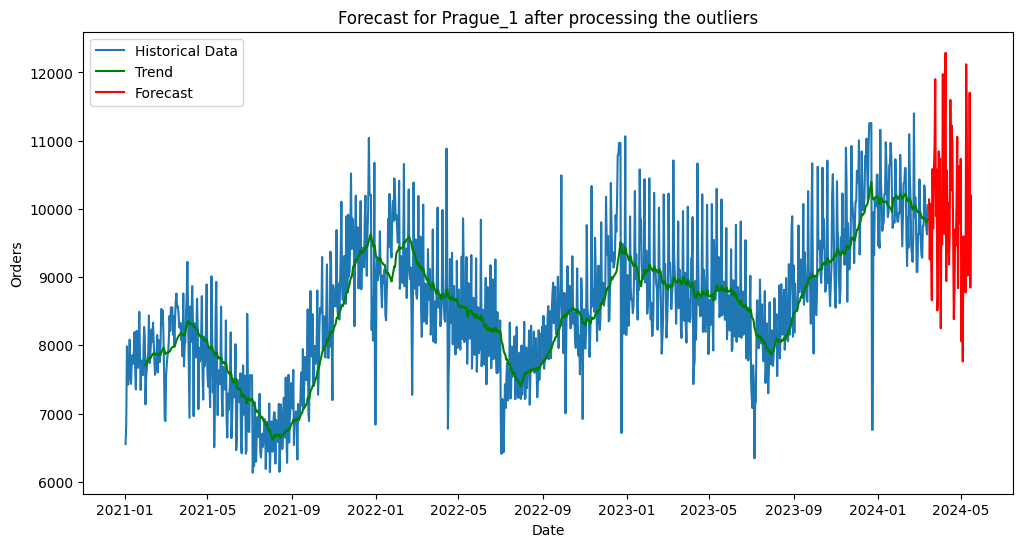

Forecast for Prague_1:
                forecast
2024-03-16  10137.297864
2024-03-17   9258.236793
2024-03-18  10073.731155
2024-03-19   9326.405450
2024-03-20   8660.489002
...                  ...
2024-05-12   9191.742104
2024-05-13   9408.049709
2024-05-14  11703.160641
2024-05-15   8846.315016
2024-05-16  10193.708241

[62 rows x 1 columns]

Outliers detected by Median Rule for Brno_1: [   0  365  722  723  730 1030 1043 1049 1057 1064 1071 1078 1079 1082
 1083 1084 1085 1086 1089 1091 1092 1093 1094 1095 1099 1100 1106 1107
 1113 1120 1121 1127 1134 1141 1148 1155 1162 1169]
Outliers detected by Three Sigma Rule for Brno_1: [   0  137  184  185  225  365  690  722  723  730 1084 1085 1086 1095]


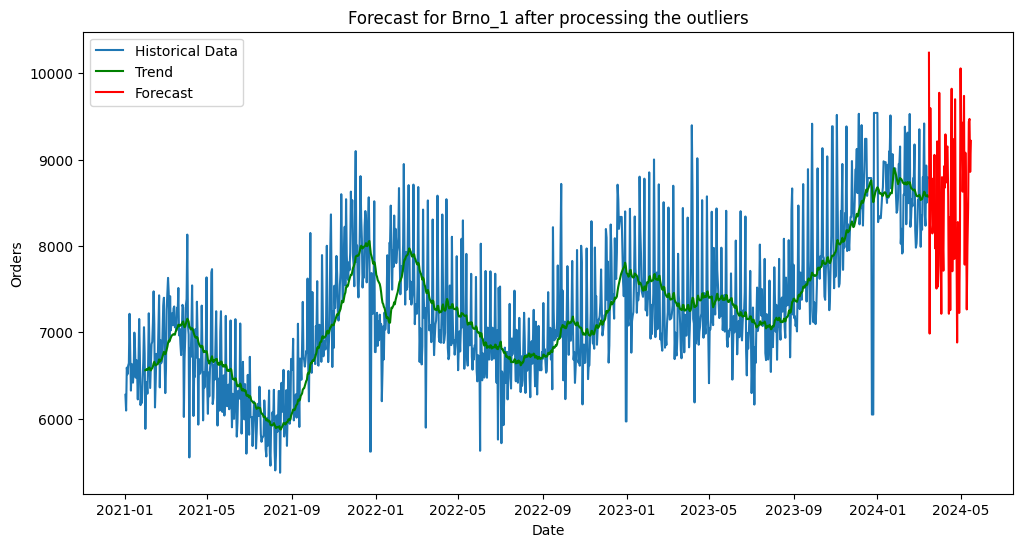

Forecast for Brno_1:
                forecast
2024-03-16  10238.224524
2024-03-17   6986.086300
2024-03-18   9596.688214
2024-03-19   8475.723321
2024-03-20   8783.419849
...                  ...
2024-05-12   8444.781761
2024-05-13   9438.981960
2024-05-14   9471.652845
2024-05-15   8858.945231
2024-05-16   9217.197677

[62 rows x 1 columns]

Outliers detected by Median Rule for Prague_2: [   0  184  357  358  365  720  721  728  730  825 1043 1064 1071 1078
 1084 1085 1086 1093 1095 1106 1113 1120 1127 1134 1148 1155 1162 1169]
Outliers detected by Three Sigma Rule for Prague_2: [   0  184  185  205  357  358  365  517  720  730 1085 1086 1095]


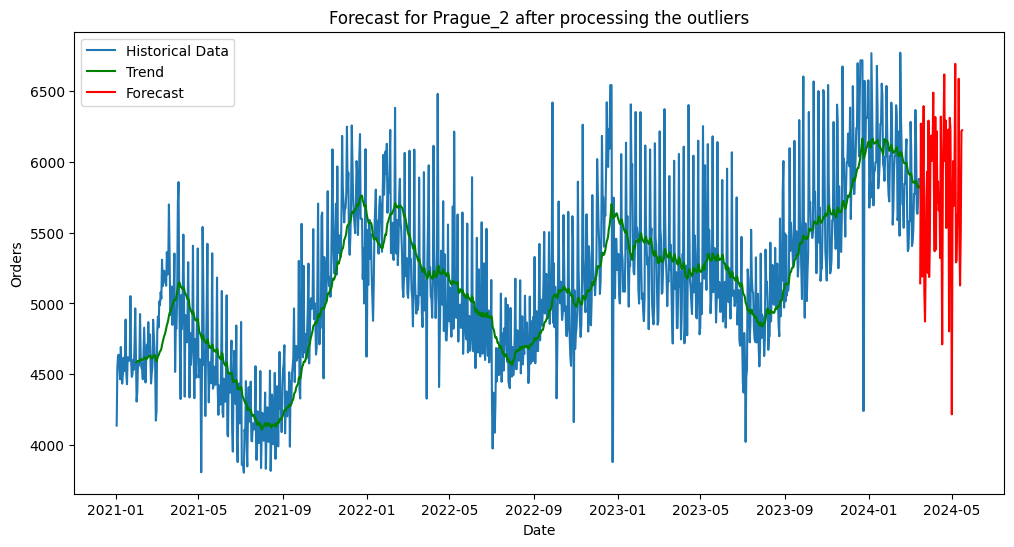

Forecast for Prague_2:
               forecast
2024-03-16  5142.246066
2024-03-17  6271.472834
2024-03-18  5955.650168
2024-03-19  5189.662916
2024-03-20  5948.443677
...                 ...
2024-05-12  5433.935430
2024-05-13  5127.195137
2024-05-14  5490.116891
2024-05-15  6217.330635
2024-05-16  6225.035514

[62 rows x 1 columns]

Outliers detected by Median Rule for Prague_3: [   0  184  185  355  357  358  365  517  720  721  722  723  730  825
 1043 1071 1078 1079 1083 1084 1085 1086 1093 1095 1099 1106 1113 1114
 1120 1127 1134 1141 1148 1155 1162 1169]
Outliers detected by Three Sigma Rule for Prague_3: [   0  183  184  185  191  205  218  232  251  357  358  365  517  722
  723  730 1085 1086 1095]


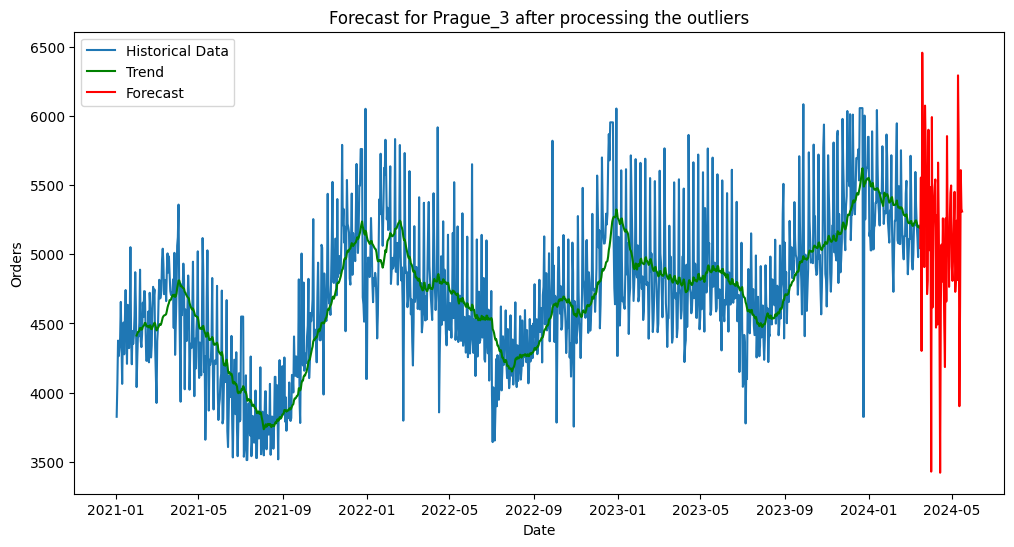

Forecast for Prague_3:
               forecast
2024-03-16  5045.516056
2024-03-17  5555.548622
2024-03-18  4301.583655
2024-03-19  6458.689926
2024-03-20  5717.631934
...                 ...
2024-05-12  3901.559540
2024-05-13  4623.668982
2024-05-14  5609.102861
2024-05-15  5328.595574
2024-05-16  5309.900716

[62 rows x 1 columns]

Outliers detected by Median Rule for Munich_1: [677 678 684 685 712 713 718 719 720 721 722 726 727 728 732 733 734 740
 741 746 747 748 753 754 755 760 761 762 767 768 769 775 776 777 781 782
 783 789 790 796 797]
Outliers detected by Three Sigma Rule for Munich_1: [566]


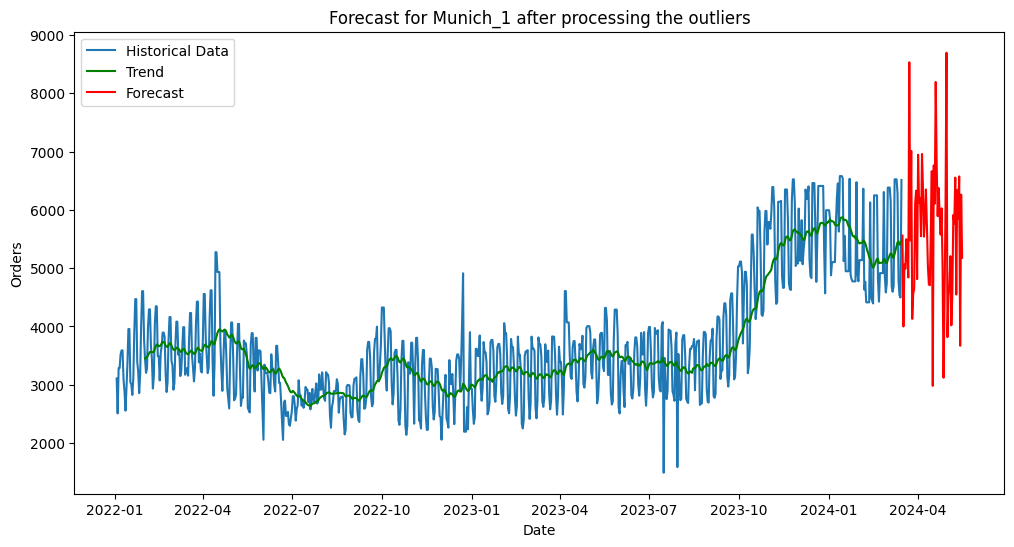

Forecast for Munich_1:
               forecast
2024-03-16  5559.550589
2024-03-17  4000.403431
2024-03-18  5062.661943
2024-03-19  4991.588169
2024-03-20  5496.657877
...                 ...
2024-05-12  5845.860513
2024-05-13  6573.244994
2024-05-14  3669.818536
2024-05-15  6261.631350
2024-05-16  5177.055666

[62 rows x 1 columns]

Outliers detected by Median Rule for Frankfurt_1: [354 355 356 357 358 362 363 364]
Outliers detected by Three Sigma Rule for Frankfurt_1: [137]


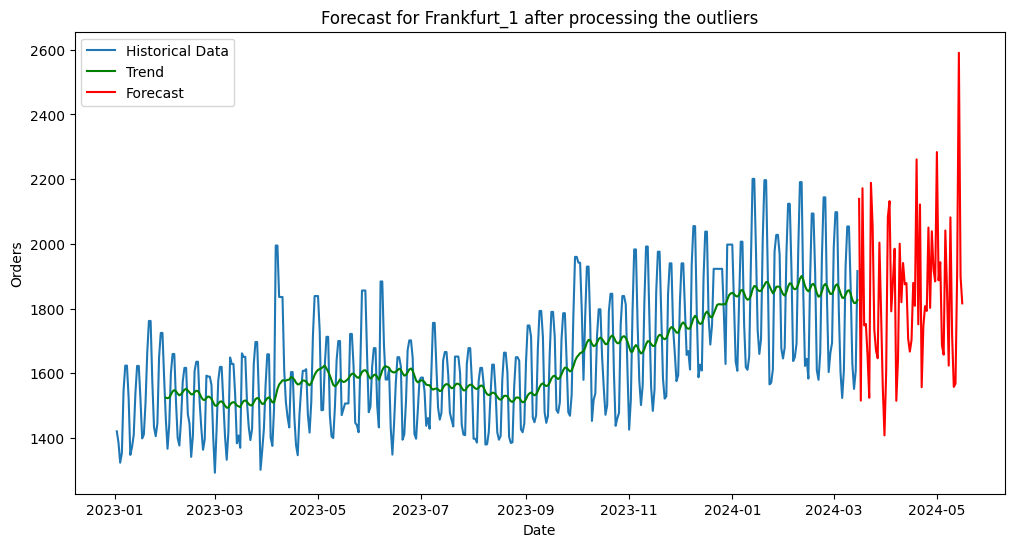

Forecast for Frankfurt_1:
               forecast
2024-03-16  2139.154909
2024-03-17  1515.843961
2024-03-18  2172.068701
2024-03-19  1748.126715
2024-03-20  1752.508839
...                 ...
2024-05-12  1568.157975
2024-05-13  1916.699272
2024-05-14  2590.839529
2024-05-15  1899.331311
2024-05-16  1816.419925

[62 rows x 1 columns]

Outliers detected by Median Rule for Budapest_1: [1081 1082 1083 1084 1085 1091 1092 1112 1161 1167]
Outliers detected by Three Sigma Rule for Budapest_1: [   0  232 1083 1084 1085]


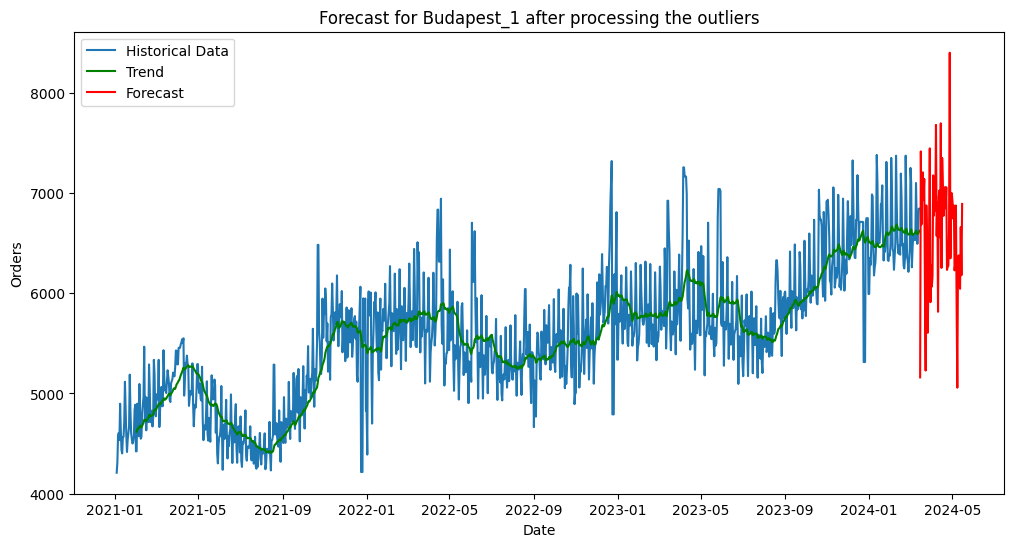

Forecast for Budapest_1:
               forecast
2024-03-15  5160.101142
2024-03-16  7414.039858
2024-03-17  6685.437391
2024-03-18  6984.390877
2024-03-19  7204.644300
...                 ...
2024-05-11  6142.025503
2024-05-12  6043.832918
2024-05-13  6658.522408
2024-05-14  6178.895356
2024-05-15  6890.155216

[62 rows x 1 columns]



In [68]:
combined_forecasts = pd.DataFrame()

for warehouse_name in warehouses:
    warehouse_data[warehouse_name] = prepare_warehouse_data(train_df, warehouse_name, exclude_years.get(warehouse_name, []))

    outliers_median = detect_outliers_median_rule(warehouse_data[warehouse_name]['orders'])
    print(f"Outliers detected by Median Rule for {warehouse_name}: {np.where(outliers_median)[0]}")

    outliers_three_sigma = detect_outliers_three_sigma(warehouse_data[warehouse_name]['orders'])
    print(f"Outliers detected by Three Sigma Rule for {warehouse_name}: {np.where(outliers_three_sigma)[0]}")

    warehouse_data[warehouse_name].loc[outliers_median | outliers_three_sigma, 'orders'] = np.nan
    warehouse_data[warehouse_name]['orders'].interpolate(method='ffill', inplace=True)

    trend = moving_average(warehouse_data[warehouse_name]['orders'], window_size=30)
    seasonal = seasonal_decompose(warehouse_data[warehouse_name]['orders'], period=365)

    forecast_results = forecast(warehouse_data[warehouse_name]['orders'], trend, seasonal, steps=62)
    combined_forecasts = pd.concat([combined_forecasts, forecast_results.rename(columns={'forecast': warehouse_name})], axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(warehouse_data[warehouse_name]['orders'], label='Historical Data')
    plt.plot(trend, label='Trend', color='green')
    plt.plot(forecast_results.index, forecast_results['forecast'], label='Forecast', color='red')
    plt.title(f'Forecast for {warehouse_name} after processing the outliers')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

    print(f"Forecast for {warehouse_name}:\n{forecast_results}\n")

# Submission

In [69]:
submission = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv')

submission[['warehouse', 'date']] = submission['id'].str.rsplit('_', n=1, expand=True)
submission['date'] = pd.to_datetime(submission['date'])

def get_forecast_value(row):
    warehouse = row['warehouse']
    date = row['date']
    return combined_forecasts.loc[date, warehouse]

submission['orders'] = submission.apply(get_forecast_value, axis=1)
submission = submission.drop(columns=['warehouse', 'date'])

In [70]:
submission.head()

,id,orders
0,Prague_1_2024-03-16,10137.297864
1,Prague_1_2024-03-17,9258.236793
2,Prague_1_2024-03-18,10073.731155
3,Prague_1_2024-03-19,9326.405450
4,Prague_1_2024-03-20,8660.489002


In [71]:
submission.to_csv('submission.csv', index=False)